In [11]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|█████████▉| 169828352/170498071 [00:33<00:00, 7181956.74it/s]Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

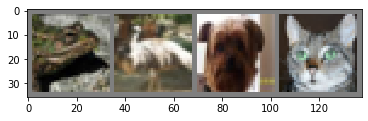

frog  bird   dog   cat


In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [42]:
%%time
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.092
[1,  4000] loss: 1.674
[1,  6000] loss: 1.528
[1,  8000] loss: 1.471
[1, 10000] loss: 1.409
[1, 12000] loss: 1.350
[2,  2000] loss: 1.288
[2,  4000] loss: 1.225
[2,  6000] loss: 1.215
[2,  8000] loss: 1.178
[2, 10000] loss: 1.171
[2, 12000] loss: 1.113
Finished Training
Wall time: 6min 53s


In [15]:
PATH = './PyTorch/PyTorchTutorial/cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()

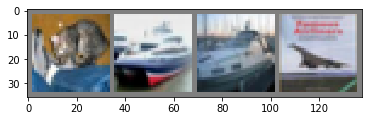

GroundTruth:  cat  ship  ship plane


In [17]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
outputs = net(images)

In [22]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:  cat  ship  ship  ship


In [39]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %


In [28]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 51 %
Accuracy of   car : 64 %
Accuracy of  bird : 66 %
Accuracy of   cat : 25 %
Accuracy of  deer : 51 %
Accuracy of   dog : 45 %
Accuracy of  frog : 54 %
Accuracy of horse : 57 %
Accuracy of  ship : 76 %
Accuracy of truck : 53 %


# GPU

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [35]:
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [36]:
%%time
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 2.055
[1,  4000] loss: 1.693
[1,  6000] loss: 1.547
[1,  8000] loss: 1.465
[1, 10000] loss: 1.393
[1, 12000] loss: 1.348
[2,  2000] loss: 1.279
[2,  4000] loss: 1.229
[2,  6000] loss: 1.209
[2,  8000] loss: 1.174
[2, 10000] loss: 1.144
[2, 12000] loss: 1.130
Finished Training
Wall time: 3min 9s


In [ ]:
[1,  2000] loss: 2.055
[1,  4000] loss: 1.693
[1,  6000] loss: 1.547
[1,  8000] loss: 1.465
[1, 10000] loss: 1.393
[1, 12000] loss: 1.348
[2,  2000] loss: 1.279
[2,  4000] loss: 1.229
[2,  6000] loss: 1.209
[2,  8000] loss: 1.174
[2, 10000] loss: 1.144
[2, 12000] loss: 1.130
Finished Training
Wall time: 3min 9s

In [38]:
net.to("cpu")

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)